# Importing necessary libraries

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm.auto import tqdm

In [ ]:
!pip install -q scikit-surprise

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 772.0/772.0 kB 6.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done


In [ ]:
from surprise import Reader, Dataset, SVD
from surprise.model_selection import cross_validate

# Exploratory Data Analysis

In [ ]:
df = pd.read_csv('/content/drive/MyDrive/Copy of combined_data_1.txt.zip',header = None, usecols = [0,1], names = ['cust_id','ratings'])

In [ ]:
df.head()

,cust_id,ratings
0,1:,NaN
1,1488844,3.0
2,822109,5.0
3,885013,4.0
4,30878,4.0


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 24058263 entries, 0 to 24058262
Data columns (total 2 columns):
 #   Column   Dtype  
---  ------   -----  
 0   cust_id  object 
 1   ratings  float64
dtypes: float64(1), object(1)
memory usage: 367.1+ MB


In [ ]:
movie_counts = df['ratings'].isna().sum()
movie_counts

4499

In [ ]:
tot_ratings = len(df['ratings'])-movie_counts

In [ ]:
tot_customers = df['cust_id'].nunique()-movie_counts

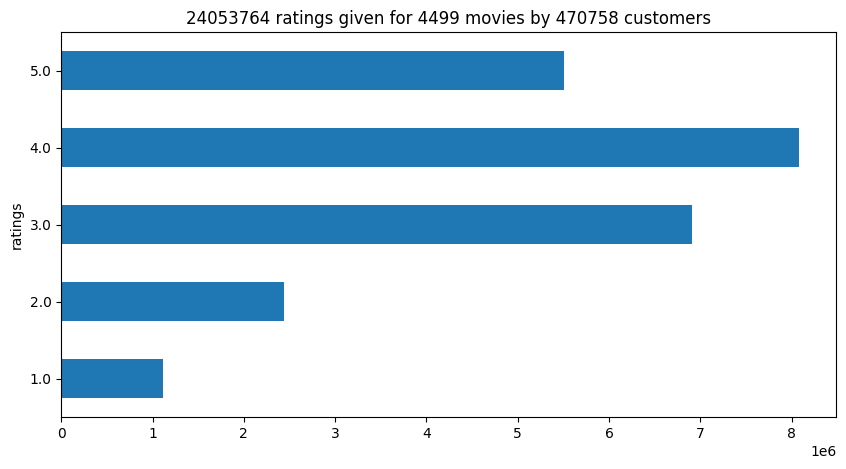

In [ ]:
df.groupby('ratings').agg('count').plot(kind = 'barh',legend = False, figsize = (10,5))
plt.title(f'{tot_ratings} ratings given for {movie_counts} movies by {tot_customers} customers')
plt.show()

# Modifying Dataframe for Analysis

In [ ]:
movie_ind = df[df['ratings'].isna()].index.to_list()

In [ ]:
movie_id = []
movie = 1
for i,j in tqdm(zip(movie_ind[1:],movie_ind[:-1])):
  temp = np.full((1,i-j-1),movie)
  movie_id = np.append(movie_id,temp)
  movie += 1

#for last record
last_record = np.full((1,len(df['ratings'])-movie_ind[-1:][0]-1),movie)
movie_id = np.append(movie_id,last_record)

0it [00:00, ?it/s]

In [ ]:
tuple(zip(movie_ind[1:],movie_ind[:-1]))

In [ ]:
movie_ind[-1:]

[24057834]

In [ ]:
len(df['ratings'])

24058263

In [ ]:
movie_ind[-1:][0]

24057834

In [ ]:
movie_id

array([1.000e+00, 1.000e+00, 1.000e+00, ..., 4.499e+03, 4.499e+03,
       4.499e+03])

In [ ]:
len(df)-movie_counts

24053764

In [ ]:
df.dropna(inplace = True)

In [ ]:
len(df)

24053764

In [ ]:
df['cust_id']=df['cust_id'].astype('int')
df['movie_id'] = movie_id.astype('int')

In [ ]:
df.head()

,cust_id,ratings,movie_id
1,1488844,3.0,1
2,822109,5.0,1
3,885013,4.0,1
4,30878,4.0,1
5,823519,3.0,1


In [ ]:
df.tail()

,cust_id,ratings,movie_id
24058258,2591364,2.0,4499
24058259,1791000,2.0,4499
24058260,512536,5.0,4499
24058261,988963,3.0,4499
24058262,1704416,3.0,4499


In [ ]:
cust_summary = df.groupby('cust_id')['ratings'].agg('count')
cust_filter = round(cust_summary.quantile(0.7))
cust_filter

52

In [ ]:
movie_summary = df.groupby('movie_id')['ratings'].agg('count')
movie_filter = round(movie_summary.quantile(0.7))
movie_filter

1799

In [ ]:
cust_drop_list = cust_summary[cust_summary<cust_filter].index.to_list()
len(cust_drop_list)

327300

In [ ]:
movie_drop_list = movie_summary[movie_summary<movie_filter].index.to_list()
len(movie_drop_list)

3149

In [ ]:
print(f'the size of the dataframe before filtering is {df.shape[0]}')

the size of the dataframe before filtering is 24053764


In [ ]:
df = df[~df['cust_id'].isin(cust_drop_list)]

In [ ]:
print(f'the size of the dataframe after filtering out the customer less than threshold is {df.shape[0]}')

the size of the dataframe after filtering the customer less than threshold is 18454563


In [ ]:
df = df[~df['movie_id'].isin(movie_drop_list)]

In [ ]:
print(f'the size of the dataframe after filtering out the movies less than threshold is {df.shape[0]}')

the size of the dataframe after filtering the movies less than threshold is 17337458


# Creating the model

In [ ]:
reader = Reader()

In [ ]:
data = Dataset.load_from_df(df[['cust_id','movie_id','ratings']][:100000],reader)

In [ ]:
model = SVD()

In [ ]:
cross_validate(model,data,cv=4)

{'test_rmse': array([0.99594792, 0.99420878, 0.99818054, 0.99938246]),
 'test_mae': array([0.78969945, 0.7903987 , 0.79522582, 0.8057174 ]),
 'fit_time': (17.296419143676758,
  1.9629876613616943,
  2.0110602378845215,
  3.4408514499664307),
 'test_time': (0.2000887393951416,
  0.15560388565063477,
  0.8638746738433838,
  0.14942049980163574)}

# Importing movies titles for testing

In [ ]:
!pip install -q chardet

In [ ]:
import chardet

In [ ]:
with open('/content/drive/MyDrive/Copy of movie_titles.csv','rb') as s:
    print(chardet.detect(s.read()))

{'encoding': 'ISO-8859-1', 'confidence': 0.73, 'language': ''}


In [ ]:
movie_data = pd.read_csv('/content/drive/MyDrive/Copy of movie_titles.csv',encoding = 'ISO-8859-1',header = None, usecols = [0,1,2], names = ['movie_id','year','movie_name'])

In [ ]:
movie_data.head()

,movie_id,year,movie_name
0,1,2003.0,Dinosaur Planet
1,2,2004.0,Isle of Man TT 2004 Review
2,3,1997.0,Character
3,4,1994.0,Paula Abdul's Get Up & Dance
4,5,2004.0,The Rise and Fall of ECW


In [ ]:
movie_data.shape

(17770, 3)

# Top 10 Movie Recommendation for a random user

In [ ]:
df['cust_id'].sample(1)

5045229    427923
Name: cust_id, dtype: int64

In [ ]:
user_427923 = movie_data.copy()

In [ ]:
user_427923 = user_427923[~user_427923['movie_id'].isin(movie_drop_list)]

In [ ]:
user_427923['pred_score'] = user_427923['movie_id'].apply(lambda x: model.predict(427923,x).est)

In [ ]:
user_427923.sort_values('pred_score',ascending = False,inplace = True)

In [ ]:
user_427923.head(10)

,movie_id,year,movie_name,pred_score
27,28,2002.0,Lilo and Stitch,3.798622
17,18,1994.0,Immortal Beloved,3.741115
29,30,2003.0,Something's Gotta Give,3.688661
2,3,1997.0,Character,3.664767
12895,12896,1994.0,Bullets Over Broadway,3.604560
12900,12901,1998.0,Star Kid,3.604560
12899,12900,2001.0,Reba: Season 1,3.604560
12898,12899,1976.0,Pinocchio,3.604560
12897,12898,1989.0,Fright Night Part II,3.604560
12896,12897,2002.0,Unspeakable,3.604560
